In [4]:
import os

# Set to parent directory (critic folder) - notebook is in experiments/ subfolder
PROJECT_PATH = '..'
os.chdir(PROJECT_PATH)
print(f"Current directory: {os.getcwd()}")
!ls -la

Current directory: /Users/Patron/Desktop/Projects/NLP/critic
total 96
drwxr-xr-x@ 14 Patron  staff    448 Dec 12 15:42 .
drwxr-xr-x@  6 Patron  staff    192 Nov 29 16:34 ..
-rw-r--r--@  1 Patron  staff  14340 Dec 12 15:41 .DS_Store
drwxr-xr-x@ 15 Patron  staff    480 Nov 28 19:13 .git
-rw-r--r--@  1 Patron  staff    370 Dec 12 14:24 .gitignore
-rw-r--r--@  1 Patron  staff  18346 Dec 12 15:00 README.md
-rw-r--r--@  1 Patron  staff    306 Dec  4 12:47 accelerate_config.yaml
drwxr-xr-x@  6 Patron  staff    192 Dec 11 20:41 data
drwxr-xr-x@ 12 Patron  staff    384 Dec 12 15:42 experiments
-rw-r--r--@  1 Patron  staff    274 Dec 10 13:45 requirements.txt
drwxr-xr-x@  8 Patron  staff    256 Dec 11 21:23 results
drwxr-xr-x@  6 Patron  staff    192 Dec 12 14:31 scripts
drwxr-xr-x@ 10 Patron  staff    320 Dec 12 14:24 src
drwxr-xr-x@  7 Patron  staff    224 Nov 10 17:21 venv


In [6]:
import json
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 120

RUNS = [
    # ---------------- TyDi ----------------
    # Phase 1 (M1): TyDi-only SFT on edits
    ("tydi_M0",   "TyDi M0 (Qwen2.5-7B Instruct)",   "tydi", "M0",           "train",  False,
     "results/tydi/baseQwen_train/summary.json"),
    ("tydi_M1_train",  "TyDi M1 (TyDi-only, train)",  "tydi", "M1",           "train", False,
     "results/tydi/eval_phase0_train/summary.json"),
    ("tydi_M1_test",   "TyDi M1 (TyDi-only, test)",   "tydi", "M1",           "test",  False,
     "results/tydi/eval_phase0_test/summary.json"),

    # Phase 2 (M2): after XQuAD
    ("tydi_M2_noanch_train", "TyDi after XQuAD (no anchor)", "tydi", "M2_no_anchor", "train", False,
     "results/tydi/eval_phase1_no_anchor_train/summary.json"),
    ("tydi_M2_anch_train",   "TyDi after XQuAD (anchor)",    "tydi", "M2_anchor",    "train", True,
     "results/tydi/eval_phase1_train/summary.json"),

    # Phase 3 (M3): after MLQA (with anchoring)
    ("tydi_M3_anch_train",   "TyDi after MLQA (anchor)",     "tydi", "M3_anchor",    "train", True,
     "results/tydi/eval_phase2_train/summary.json"),

    # ---------------- XQuAD ----------------
    # Phase 1: zero-shot from TyDi model
    ("xquad_M1_train", "XQuAD zero-shot from TyDi (M1)", "xquad", "M1_zero", "train", False,
     "results/xquad/eval_phase0_train/summary.json"),

    # Phase 2 (M2): XQuAD SFT, with & without anchoring
    ("xquad_M2_noanch_train", "XQuAD M2 (no anchor, train)", "xquad", "M2_no_anchor", "train", False,
     "results/xquad/eval_phase1_no_anchor_train/summary.json"),
    ("xquad_M2_anch_train",   "XQuAD M2 (anchor, train)",    "xquad", "M2_anchor",    "train", True,
     "results/xquad/eval_phase1_train/summary.json"),
    ("xquad_M2_anch_test",    "XQuAD M2 (anchor, test)",     "xquad", "M2_anchor",    "test",  True,
     "results/xquad/eval_phase1_test/summary.json"),

    # Phase 3 (M3): after MLQA
    ("xquad_M3_anch_train",   "XQuAD after MLQA (anchor)",   "xquad", "M3_anchor",    "train", True,
     "results/xquad/eval_phase2_train/summary.json"),

    # ---------------- MLQA ----------------
    # Phase 2: zero-shot from XQuAD-anchored model
    ("mlqa_M2_zero_train", "MLQA zero-shot from XQuAD (M2)", "mlqa", "M2_zero",      "train", False,
     "results/mlqa/eval_phase1/summary.json"),

    # Phase 3 (M3): MLQA SFT, with & without anchoring
    ("mlqa_M3_noanch_train", "MLQA M3 (no anchor, train)",   "mlqa", "M3_no_anchor", "train", False,
     "results/mlqa/eval_phase2_no_anchor_train/summary.json"),
    ("mlqa_M3_anch_train",   "MLQA M3 (anchor, train)",      "mlqa", "M3_anchor",    "train", True,
     "results/mlqa/eval_phase2_train/summary.json"),
    ("mlqa_M3_anch_test",    "MLQA M3 (anchor, test)",       "mlqa", "M3_anchor",    "test",  True,
     "results/mlqa/eval_phase2_test/summary.json"),
]

lang_records = []
overall_records = []
xling_records = []

for run_id, label, dataset, phase, split, anchor, path in RUNS:
    try:
        with open(path, "r") as f:
            summary = json.load(f)
    except FileNotFoundError:
        print(f"[WARN] Missing file: {path}  (skipping)")
        continue

    overall = summary["overall"]
    by_lang = summary["by_language"]
    cross = summary.get("cross_lingual", {})

    overall_records.append({
        "run_id": run_id,
        "label": label,
        "dataset": dataset,
        "phase": phase,
        "split": split,
        "anchor": anchor,
        "num_samples": overall["num_samples"],
        "EM": overall["exact_match"],
        "F1": overall["span_f1"],
        "ROUGE_L": overall["rouge_l"],
        "BLEURT": overall["bleurt"],
        "LLM_correct": overall["llm_correctness"],
        "LLM_quality": overall["llm_quality"],
        "disparity": cross.get("disparity", None),
        "XLTR_mean": cross.get("xltr_mean", None),
    })

    for lang, stats in by_lang.items():
        lang_records.append({
            "run_id": run_id,
            "label": label,
            "dataset": dataset,
            "phase": phase,
            "split": split,
            "anchor": anchor,
            "lang": lang,
            "EM": stats["exact_match"],
            "F1": stats["span_f1"],
            "ROUGE_L": stats["rouge_l"],
            "BLEURT": stats["bleurt"],
            "LLM_correct": stats["llm_correctness"],
            "LLM_quality": stats["llm_quality"],
        })

    if cross:
        gaps = cross.get("group_gaps", {})
        xling_records.append({
            "run_id": run_id,
            "label": label,
            "dataset": dataset,
            "phase": phase,
            "split": split,
            "anchor": anchor,
            "disparity": cross.get("disparity"),
            "XLTR_mean": cross.get("xltr_mean"),
            "HIGH": gaps.get("HIGH"),
            "MID": gaps.get("MID"),
            "LOW": gaps.get("LOW"),
            "HIGH_MID_gap": gaps.get("HIGH-MID"),
            "HIGH_LOW_gap": gaps.get("HIGH-LOW"),
            "MID_LOW_gap": gaps.get("MID-LOW"),
        })

lang_df = pd.DataFrame(lang_records)
overall_df = pd.DataFrame(overall_records)
xling_df = pd.DataFrame(xling_records)

print("lang_df shape:", lang_df.shape)
print("overall_df shape:", overall_df.shape)
print("xling_df shape:", xling_df.shape)


lang_df shape: (78, 13)
overall_df shape: (15, 15)
xling_df shape: (15, 14)


In [ ]:
def plot_per_language_metric(dataset, metric="F1", title_suffix="span F1"):
    """
    dataset: 'tydi' | 'xquad' | 'mlqa'
    metric: one of ['F1', 'ROUGE_L', 'BLEURT', 'LLM_correct', 'LLM_quality']
    """
    subset = lang_df[(lang_df["dataset"] == dataset) & (lang_df["split"] == "train")]
    if subset.empty:
        print(f"No data for dataset={dataset}")
        return

    subset = subset.copy()
    subset["phase_label"] = subset.apply(
        lambda r: f"{r['phase']}{' (anch)' if r['anchor'] else ' (no anch)'}",
        axis=1
    )

    pivot = subset.pivot_table(
        index="lang",
        columns="phase_label",
        values=metric,
        aggfunc="mean"
    ).sort_index(axis=1)

    ax = pivot.plot(kind="bar", figsize=(8, 4))
    ax.set_title(f"{dataset.upper()}: per-language {title_suffix} across phases (train)")
    ax.set_ylabel(title_suffix)
    ax.set_xlabel("Language")
    # Keeping y-range reasonable even when values are small
    ax.set_ylim(0, max(0.25, pivot.max().max() * 1.2))
    plt.xticks(rotation=0)
    plt.legend(title="Phase")
    plt.tight_layout()
    plt.show()


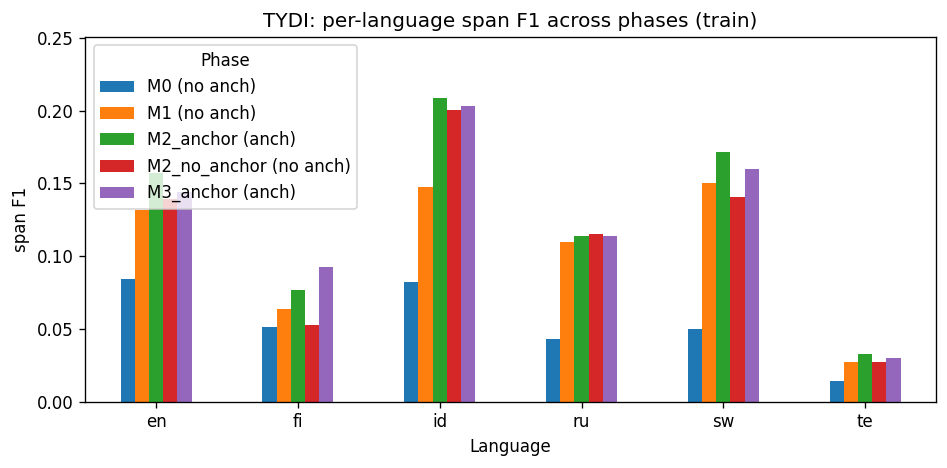

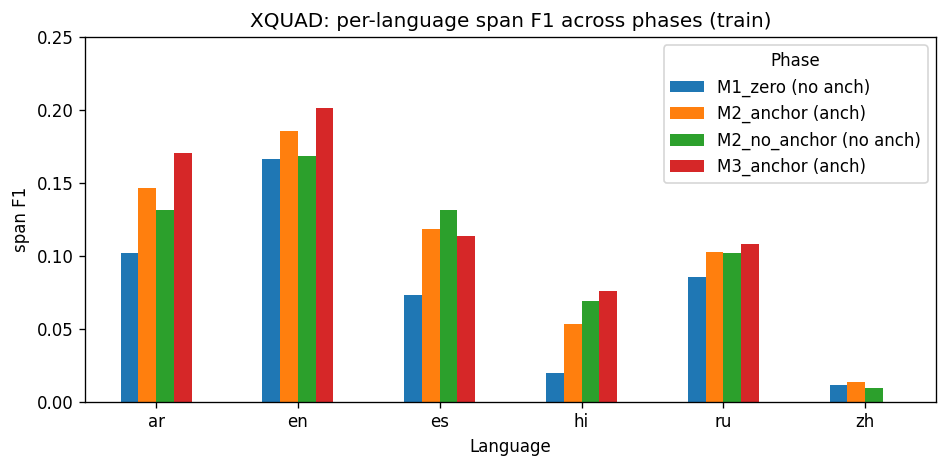

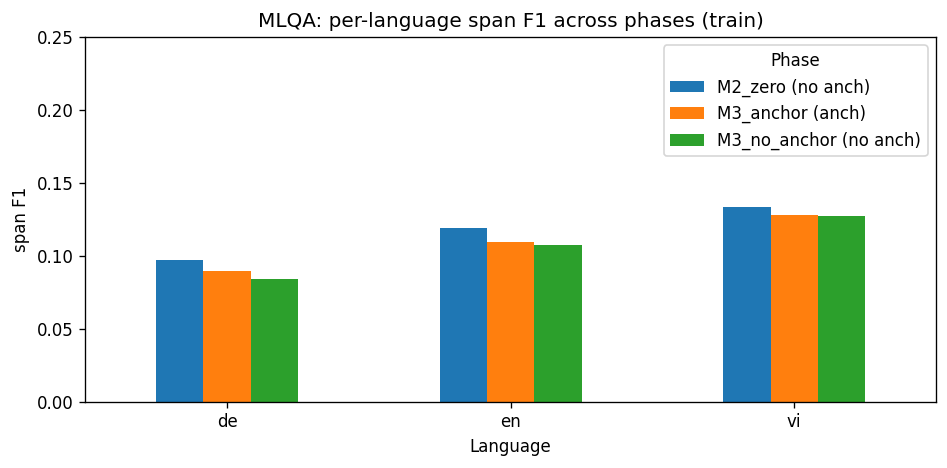

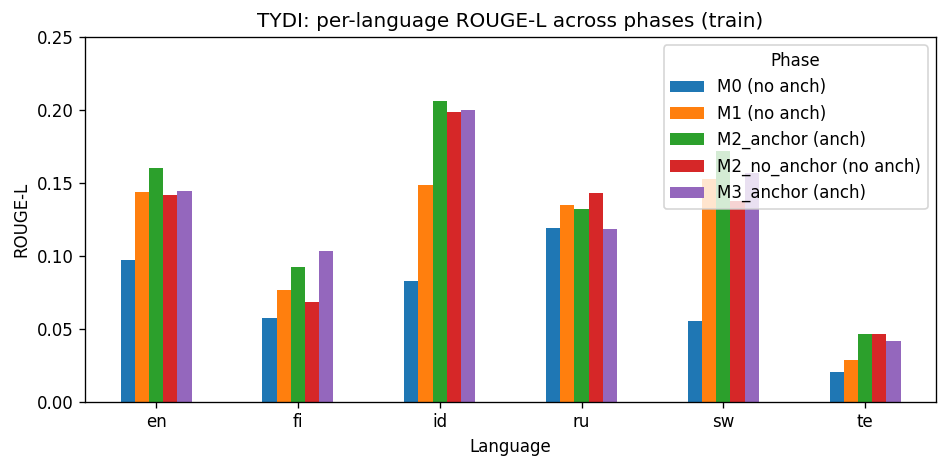

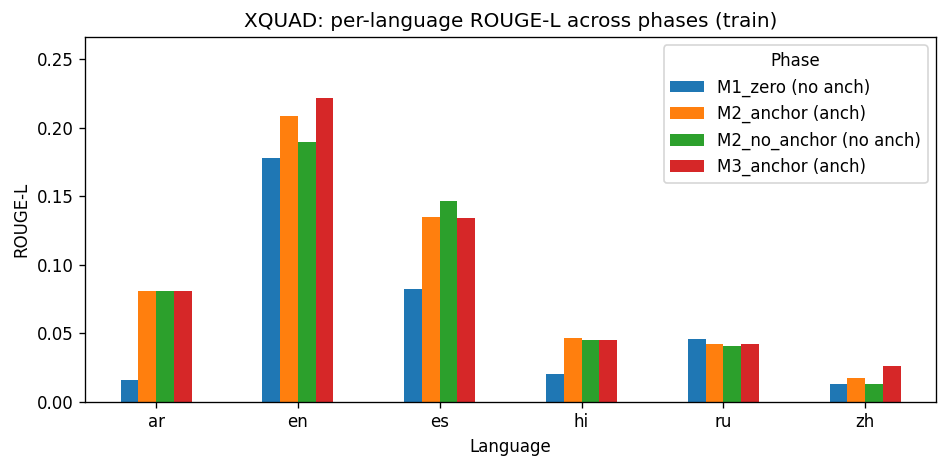

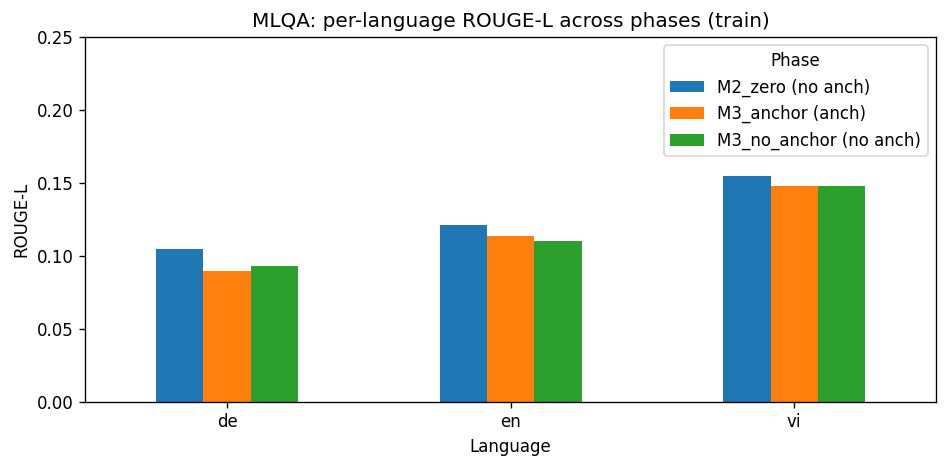

In [ ]:
plot_per_language_metric("tydi",  metric="F1",       title_suffix="span F1")
plot_per_language_metric("xquad", metric="F1",       title_suffix="span F1")
plot_per_language_metric("mlqa",  metric="F1",       title_suffix="span F1")

plot_per_language_metric("tydi",  metric="ROUGE_L",  title_suffix="ROUGE-L")
plot_per_language_metric("xquad", metric="ROUGE_L",  title_suffix="ROUGE-L")
plot_per_language_metric("mlqa",  metric="ROUGE_L",  title_suffix="ROUGE-L")


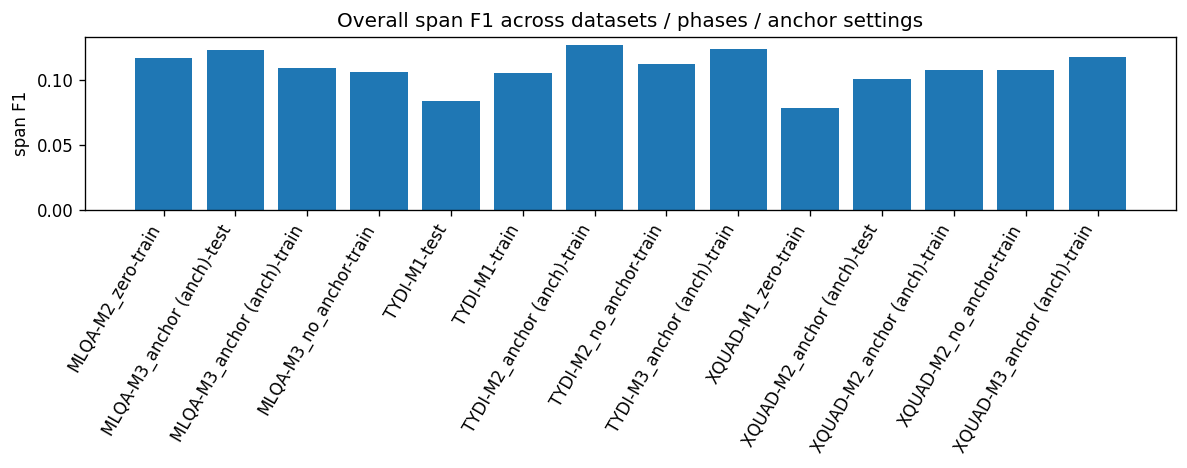

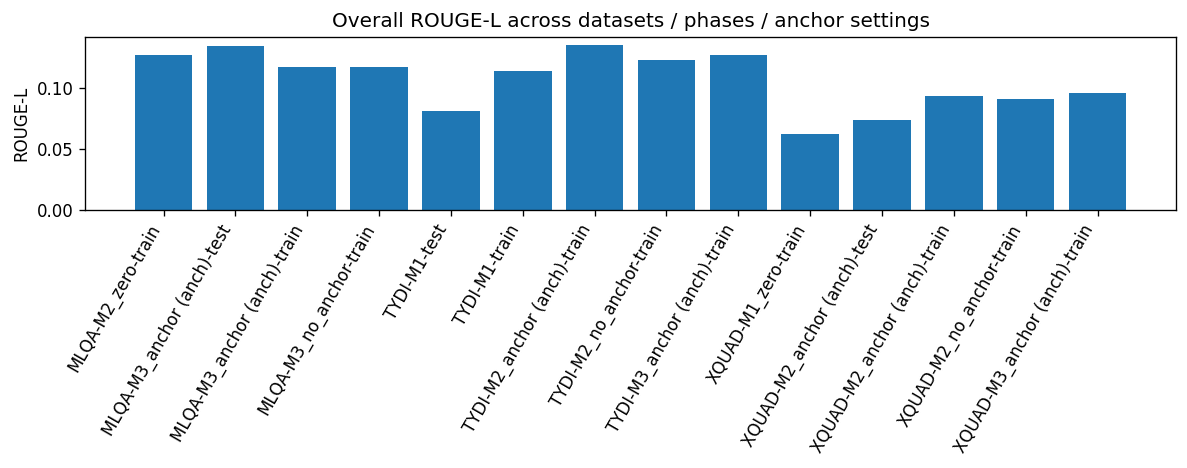

In [ ]:
def plot_overall_metric(metric="F1", title_suffix="span F1"):
    df = overall_df.copy()
    df["phase_label"] = df.apply(
        lambda r: f"{r['dataset'].upper()}-{r['phase']}{' (anch)' if r['anchor'] else ''}-{r['split']}",
        axis=1
    )

    df = df.sort_values(["dataset", "phase", "anchor", "split"])
    plt.figure(figsize=(10, 4))
    plt.bar(df["phase_label"], df[metric])
    plt.xticks(rotation=60, ha="right")
    plt.ylabel(title_suffix)
    plt.title(f"Overall {title_suffix} across datasets / phases / anchor settings")
    plt.tight_layout()
    plt.show()

plot_overall_metric(metric="F1",      title_suffix="span F1")
plot_overall_metric(metric="ROUGE_L", title_suffix="ROUGE-L")


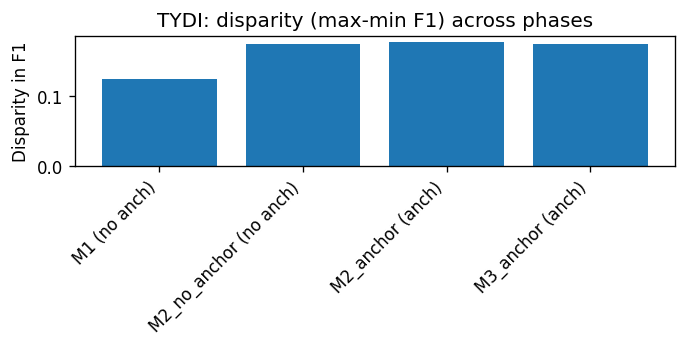

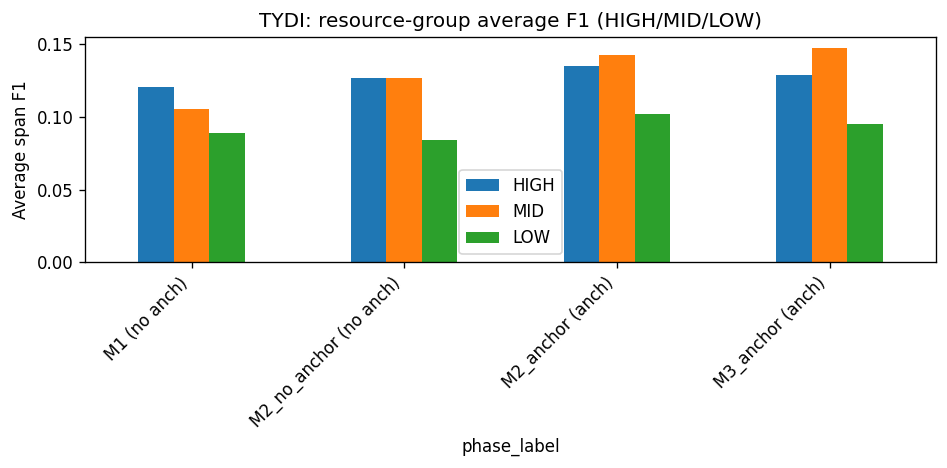

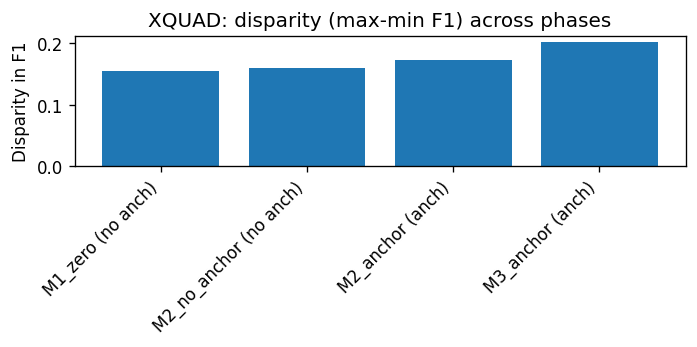

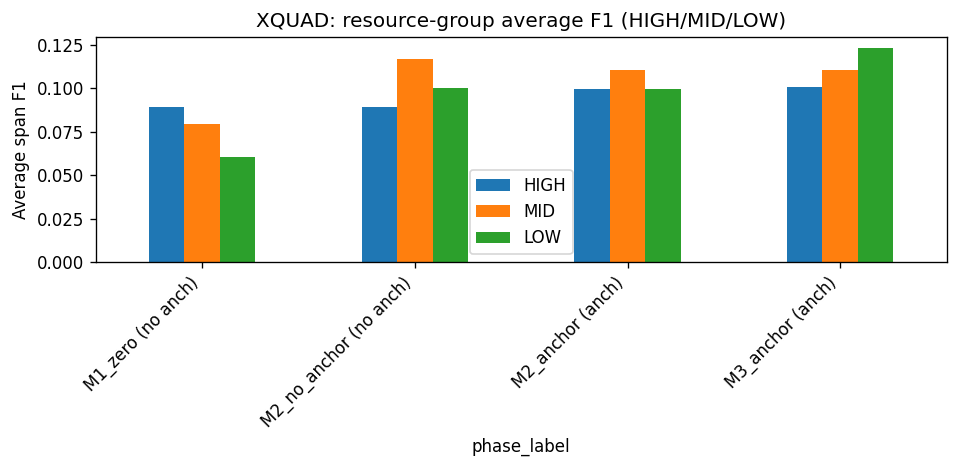

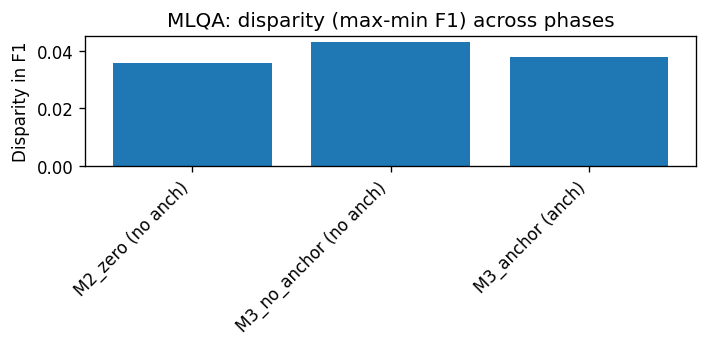

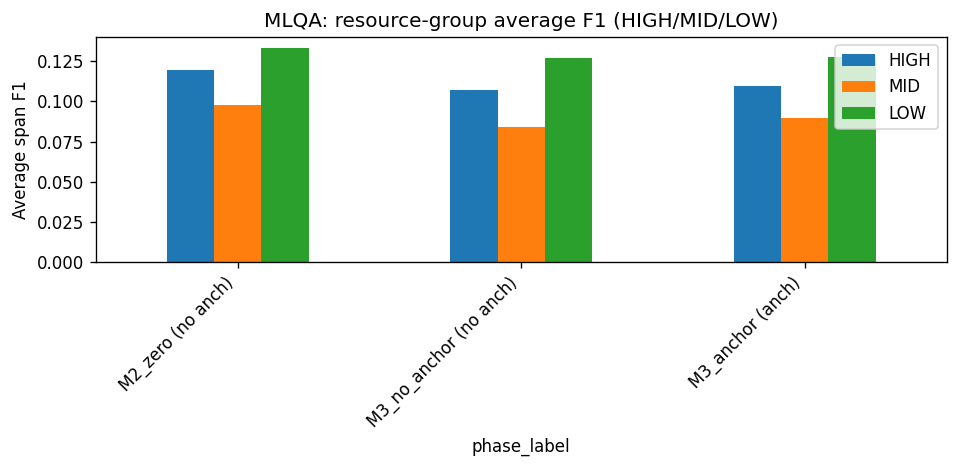

In [ ]:
def plot_disparity_and_groups(dataset):
    subset = xling_df[(xling_df["dataset"] == dataset) & (xling_df["split"] == "train")]
    if subset.empty:
        print(f"No xling data for dataset={dataset}")
        return

    subset = subset.copy()
    subset["phase_label"] = subset.apply(
        lambda r: f"{r['phase']}{' (anch)' if r['anchor'] else ' (no anch)'}",
        axis=1
    )

    # 1) Disparity (max-min F1 across languages)
    plt.figure(figsize=(6, 3))
    plt.bar(subset["phase_label"], subset["disparity"])
    plt.title(f"{dataset.upper()}: disparity (max-min F1) across phases")
    plt.ylabel("Disparity in F1")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # 2) Resource group averages (HIGH/MID/LOW)
    groups = subset.set_index("phase_label")[["HIGH", "MID", "LOW"]]
    ax = groups.plot(kind="bar", figsize=(8, 4))
    ax.set_title(f"{dataset.upper()}: resource-group average F1 (HIGH/MID/LOW)")
    ax.set_ylabel("Average span F1")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

plot_disparity_and_groups("tydi")
plot_disparity_and_groups("xquad")
plot_disparity_and_groups("mlqa")


In [ ]:
def plot_train_vs_test(dataset, phase):
    subset = overall_df[(overall_df["dataset"] == dataset) & (overall_df["phase"] == phase)]
    if subset.empty or subset["split"].nunique() < 2:
        print(f"Need both train & test for {dataset}, phase={phase}")
        return

    sub = subset.set_index("split")
    plt.figure(figsize=(4, 3))
    plt.bar(["train", "test"], [sub.loc["train","F1"], sub.loc["test","F1"]])
    plt.title(f"{dataset.upper()} {phase}: train vs. test span F1")
    plt.ylabel("Span F1")
    plt.ylim(0, max(sub["F1"]) * 1.3)
    plt.tight_layout()
    plt.show()


plot_train_vs_test("tydi",  "M1")        # TyDi-only model
plot_train_vs_test("xquad", "M2_anchor") # After XQuAD + anchor
plot_train_vs_test("mlqa",  "M3_anchor") # After MLQA + anchor


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_all_datasets_train_test_two_scales(overall_df, phase_for_dataset=None):
    """
    Make 2 plots total (TRAIN / TEST).
    Left y-axis: lexical metrics (F1, ROUGE-L)
    Right y-axis: LLM metrics (LLM_correctness, LLM_quality)
    Datasets are grouped per metric with different colors.
    """

    if phase_for_dataset is None:
        phase_for_dataset = {
            "tydi":  "M3_anchor",
            "xquad": "M3_anchor",
            "mlqa":  "M3_anchor",
        }

    # Canonical metrics and common column-name variants
    metric_candidates = {
        "F1": [
            "F1", "f1", "span_f1", "span_f1_mean"
        ],
        "ROUGE-L": [
            "ROUGE-L", "ROUGE_L", "rouge_l", "rougeL", "rouge_l_mean"
        ],
        "LLM_correct": [
            "LLM_correct", "llm_correctness", "llm_correctness_mean"
        ],
        "LLM_quality": [
            "LLM_quality", "llm_quality", "llm_quality_mean"
        ]
    }

    pretty_labels = {
        "F1": "Span F1",
        "ROUGE-L": "ROUGE-L",
        "LLM_correct": "LLM correct",
        "LLM_quality": "LLM language quality"
    }

    # Map canonical -> actual df columns
    df_cols = set(overall_df.columns)
    metric_col_map = {}
    for canonical, candidates in metric_candidates.items():
        for c in candidates:
            if c in df_cols:
                metric_col_map[canonical] = c
                break
        if canonical not in metric_col_map:
            print(f"[warn] metric '{canonical}' not found in dataframe (candidates={candidates})")

    # Split into lexical vs LLM groups (and keep only ones that exist)
    lexical_metrics = [m for m in ["F1", "ROUGE-L"] if m in metric_col_map]
    llm_metrics     = [m for m in ["LLM_correct", "LLM_quality"] if m in metric_col_map]

    if not lexical_metrics and not llm_metrics:
        print("No usable metrics found, check overall_df.columns.")
        return

    datasets = list(phase_for_dataset.keys())
    dataset_labels = [d.upper() for d in datasets]
    colors = plt.cm.tab10(np.arange(len(datasets)))

    bar_width = 0.22
    splits = ["train", "test"]

    for split in splits:
        fig, ax1 = plt.subplots(figsize=(9, 4))
        ax2 = ax1.twinx()

        # Positions for x axis
        n_lex = len(lexical_metrics)
        n_llm = len(llm_metrics)
        x_lex = np.arange(n_lex)
        x_llm = np.arange(n_llm) + n_lex + 0.7  # offset so llm metrics are to the right

        ymax_lex = 0.0
        ymax_llm = 0.0

        # For legend (only add once per dataset)
        handles = []
        labels  = []

        for i, dataset in enumerate(datasets):
            phase = phase_for_dataset[dataset]
            row = overall_df[
                (overall_df["dataset"] == dataset) &
                (overall_df["phase"]   == phase) &
                (overall_df["split"]   == split)
            ]
            if row.empty:
                print(f"[warn] missing row for dataset={dataset}, phase={phase}, split={split}")
                continue
            row = row.iloc[0]

            offset = (i - (len(datasets)-1)/2) * bar_width

            # Lexical metrics on left y-axis
            if lexical_metrics:
                vals_lex = [row[metric_col_map[m]] for m in lexical_metrics]
                ymax_lex = max(ymax_lex, max(vals_lex))
                pos_lex = x_lex + offset
                h1 = ax1.bar(pos_lex, vals_lex,
                             width=bar_width,
                             color=colors[i],
                             alpha=0.6,
                             label=dataset_labels[i])
            else:
                h1 = None

            # LLM metrics on right y-axis
            if llm_metrics:
                vals_llm = [row[metric_col_map[m]] for m in llm_metrics]
                ymax_llm = max(ymax_llm, max(vals_llm))
                pos_llm = x_llm + offset
                ax2.bar(pos_llm, vals_llm,
                        width=bar_width,
                        color=colors[i],
                        alpha=0.7)  

            if h1 is not None:
                handles.append(h1[0])
                labels.append(dataset_labels[i])

        # X ticks & labels
        xticks = list(x_lex) + list(x_llm)
        xtick_labels = [pretty_labels[m] for m in lexical_metrics] + \
                       [pretty_labels[m] for m in llm_metrics]
        ax1.set_xticks(xticks)
        ax1.set_xticklabels(xtick_labels, rotation=20)

        ax1.set_ylabel("Lexical score (F1 / ROUGE-L)")
        ax2.set_ylabel("LLM scores (1–5)")

        if ymax_lex > 0:
            ax1.set_ylim(0, ymax_lex * 1.3)
        if ymax_llm > 0:
            ax2.set_ylim(0, ymax_llm * 1.3)

        ax1.set_title(f"All datasets – {split.upper()} metrics ")
        ax1.legend(handles, labels, loc="upper left")
        fig.tight_layout()
        plt.show()


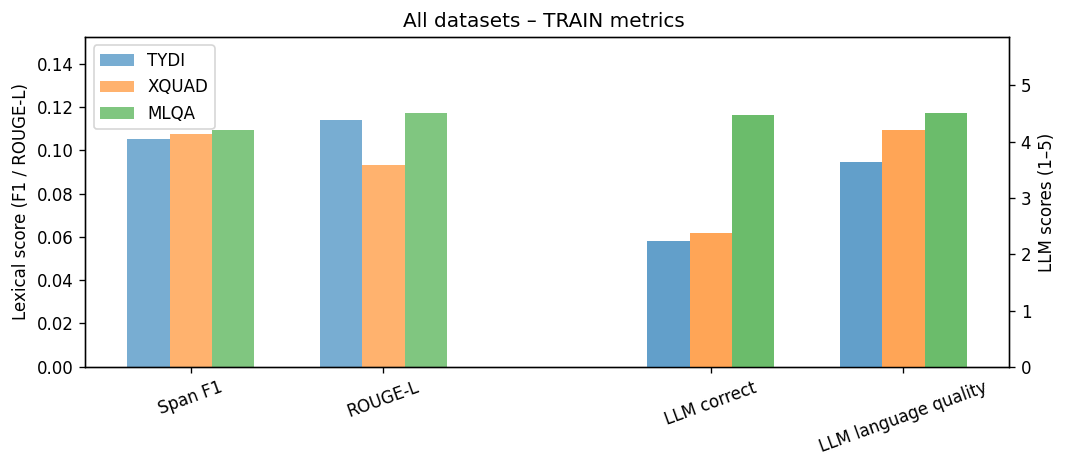

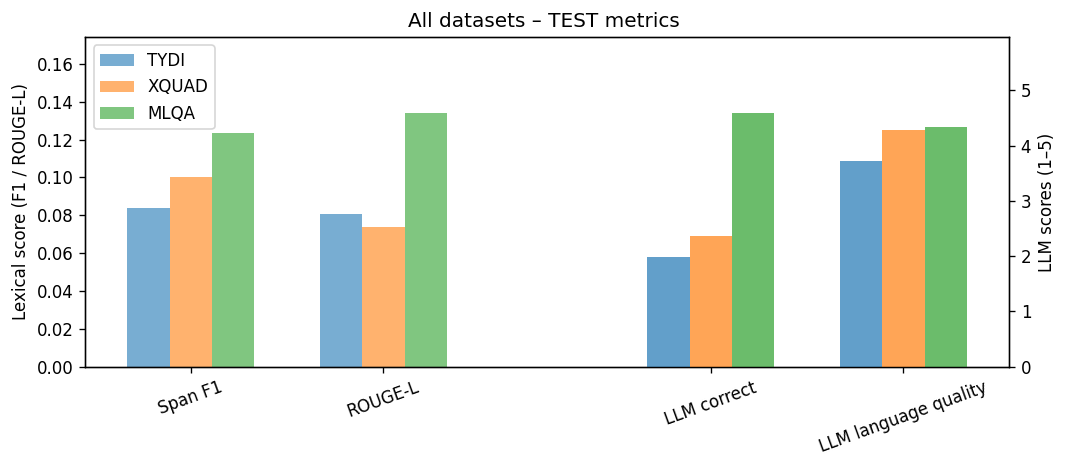

In [ ]:
phase_map = {
    "tydi":  "M1",         
    "xquad": "M2_anchor",
    "mlqa":  "M3_anchor",
}

plot_all_datasets_train_test_two_scales(overall_df, phase_for_dataset=phase_map)


In [ ]:
print(overall_df.columns.tolist())
print(overall_df.filter(like='correct', axis=1).head())


['run_id', 'label', 'dataset', 'phase', 'split', 'anchor', 'num_samples', 'EM', 'F1', 'ROUGE_L', 'BLEURT', 'LLM_correct', 'LLM_quality', 'disparity', 'XLTR_mean']
   LLM_correct
0     2.065217
1     2.237458
2     1.991667
3     2.090301
4     2.185619


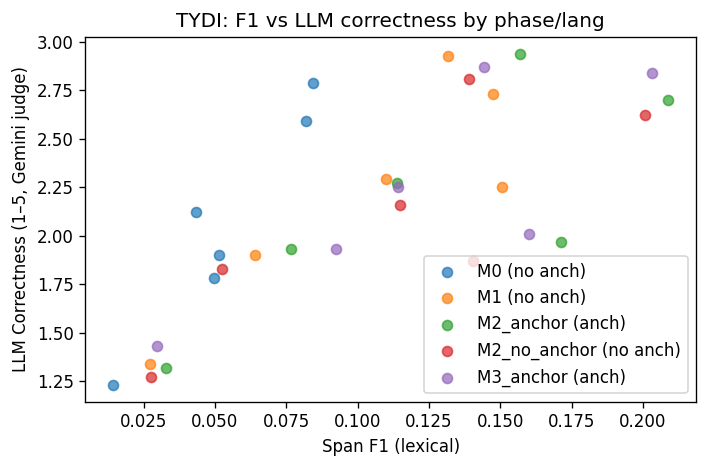

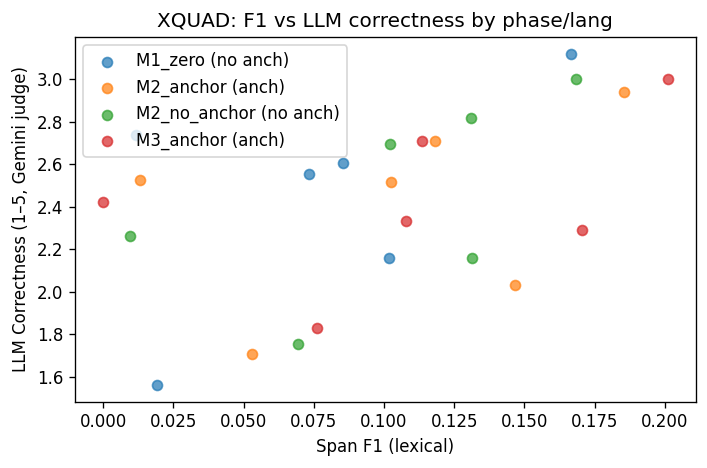

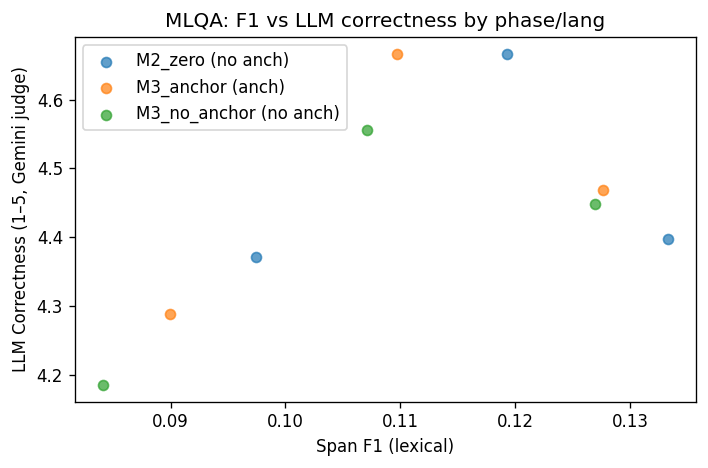

In [ ]:
def scatter_f1_vs_llm(dataset):
    subset = lang_df[(lang_df["dataset"] == dataset) & (lang_df["split"] == "train")]
    if subset.empty:
        print(f"No data for {dataset}")
        return

    subset = subset.copy()
    subset["phase_label"] = subset.apply(
        lambda r: f"{r['phase']}{' (anch)' if r['anchor'] else ' (no anch)'}",
        axis=1
    )

    plt.figure(figsize=(6, 4))
    for phase_label, group in subset.groupby("phase_label"):
        plt.scatter(group["F1"], group["LLM_correct"], label=phase_label, alpha=0.7)

    plt.xlabel("Span F1 (lexical)")
    plt.ylabel("LLM Correctness (1–5, Gemini judge)")
    plt.title(f"{dataset.upper()}: F1 vs LLM correctness by phase/lang")
    plt.legend()
    plt.tight_layout()
    plt.show()

scatter_f1_vs_llm("tydi")
scatter_f1_vs_llm("xquad")
scatter_f1_vs_llm("mlqa")


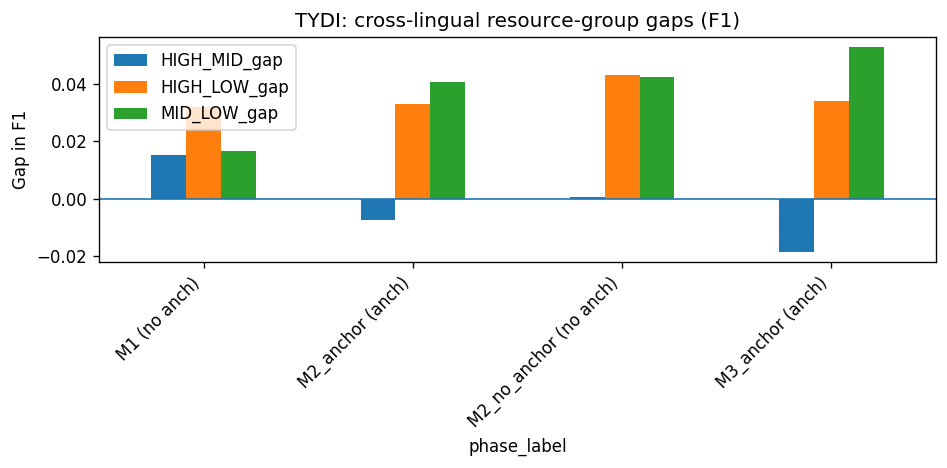

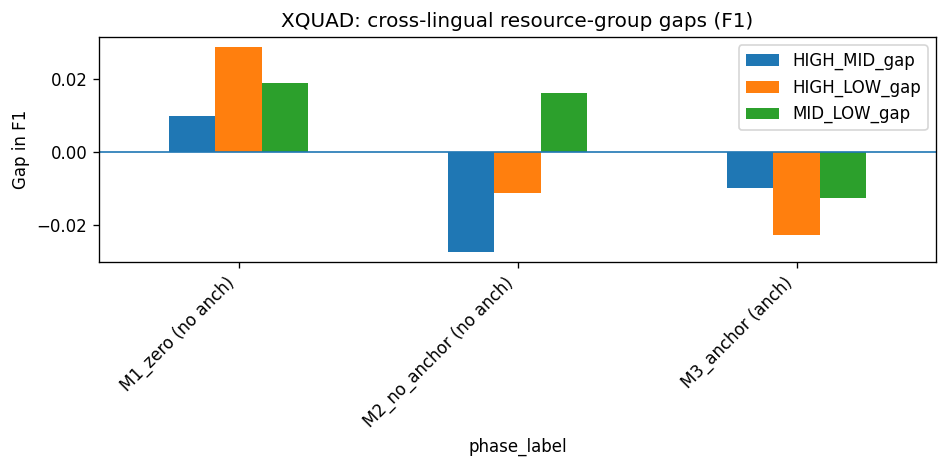

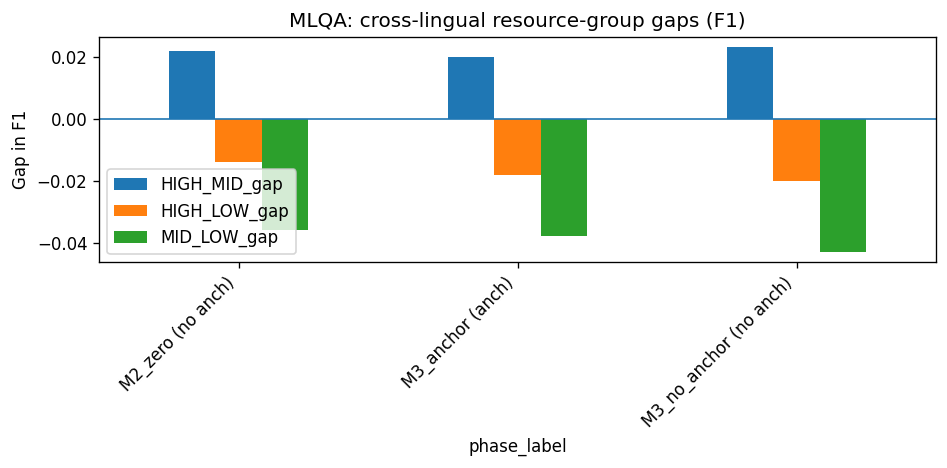

In [ ]:
def plot_group_gaps(dataset):
    subset = xling_df[(xling_df["dataset"] == dataset) & (xling_df["split"] == "train")]
    if subset.empty:
        print(f"No xling data for dataset={dataset}")
        return

    subset = subset.copy()
    subset["phase_label"] = subset.apply(
        lambda r: f"{r['phase']}{' (anch)' if r['anchor'] else ' (no anch)'}",
        axis=1
    )
    subset = subset.sort_values("phase_label")

    gaps = subset.set_index("phase_label")[["HIGH_MID_gap", "HIGH_LOW_gap", "MID_LOW_gap"]]

    ax = gaps.plot(kind="bar", figsize=(8, 4))
    ax.set_title(f"{dataset.upper()}: cross-lingual resource-group gaps (F1)")
    ax.set_ylabel("Gap in F1")
    plt.xticks(rotation=45, ha="right")
    plt.axhline(0, linewidth=1)
    plt.tight_layout()
    plt.show()

# For all three datasets:
plot_group_gaps("tydi")
plot_group_gaps("xquad")
plot_group_gaps("mlqa")
